In [1]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [2]:
filenames = glob.glob(str('midi_files/*.mid'))
print('Number of files:', len(filenames))

Number of files: 92


In [3]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [5]:
sample_file = filenames[1]
print(sample_file)

midi_files\8.mid


In [6]:
raw_notes = midi_to_notes(sample_file)
raw_notes

,pitch,start,end,step,duration
0,72,0.000000,0.428571,0.000000,0.428571
1,72,0.000000,0.428571,0.000000,0.428571
2,64,0.000000,0.571428,0.000000,0.571428
3,67,0.642857,0.745535,0.642857,0.102678
4,72,0.749999,0.852678,0.107143,0.102678
...,...,...,...,...,...
169,76,34.285680,35.142822,0.000000,0.857142
170,79,34.285680,35.142822,0.000000,0.857142
171,79,34.285680,35.142822,0.000000,0.857142
172,60,34.285680,35.433000,0.000000,1.147320


In [7]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['C5', 'C5', 'E4', 'G4', 'C5', 'D5', 'A#4', 'D4', 'F4', 'A#4'],
      dtype='<U3')

In [8]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
    if count:
        title = f'First {count} notes'
    else:
        title = f'Whole track'
        count = len(notes['pitch'])
        plt.figure(figsize=(20, 4))
        plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
        plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
        plt.plot(
          plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
        plt.xlabel('Time [s]')
        plt.ylabel('Pitch')
        _ = plt.title(title)

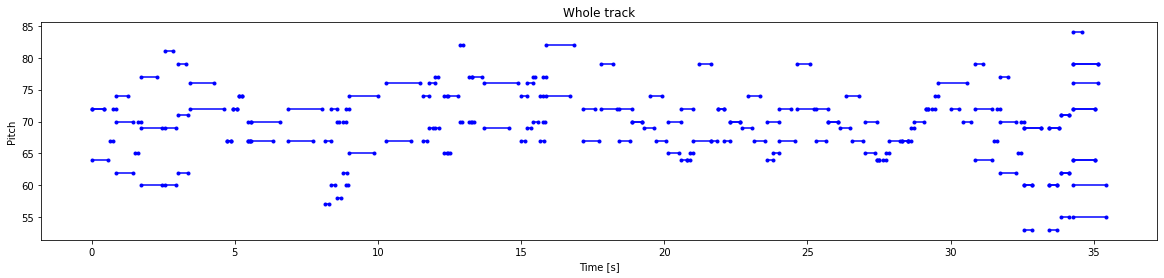

In [9]:
plot_piano_roll(raw_notes)

In [10]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
    plt.figure(figsize=[15, 5])
    plt.subplot(1, 3, 1)
    sns.histplot(notes, x="pitch", bins=20)

    plt.subplot(1, 3, 2)
    max_step = np.percentile(notes['step'], 100 - drop_percentile)
    sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

    plt.subplot(1, 3, 3)
    max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
    sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

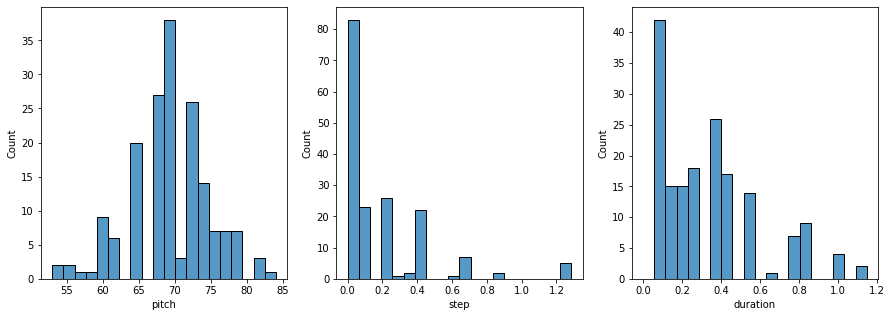

In [11]:
plot_distributions(raw_notes)

In [12]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        note = pretty_midi.Note(
            velocity=velocity,
            pitch=int(note['pitch']),
            start=start,
            end=end,
        )
        instrument.notes.append(note)
        prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

In [13]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
    notes = midi_to_notes(f)
    all_notes.append(notes)
all_notes = pd.concat(all_notes)

In [14]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 3099


In [15]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [16]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [17]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  
    """Returns TF Dataset of sequence and label examples."""
    seq_length = seq_length+1

  # Take 1 extra for the labels
    windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)

  # Normalize note pitch
    def scale_pitch(x):
        x = x/[vocab_size,1.0,1.0]
        return x

  # Split the labels
    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

        return scale_pitch(inputs), labels

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [18]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [19]:
for seq, target in seq_ds.take(1):
    print('sequence shape:', seq.shape)
    print('sequence elements (first 10):', seq[0: 10])
    print()
    print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.40625   0.        0.454545 ]
 [0.4453125 0.        0.454545 ]
 [0.40625   0.545454  0.454545 ]
 [0.4453125 0.        0.454545 ]
 [0.40625   1.636362  0.454545 ]
 [0.4609375 0.        0.454545 ]
 [0.40625   0.545454  0.454545 ]
 [0.4609375 0.        0.454545 ]
 [0.40625   1.636362  0.454545 ]
 [0.46875   0.        0.454545 ]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=81.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.06818174999999904>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.4545450000000013>}


In [20]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [21]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

In [22]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

In [23]:
losses = model.evaluate(train_ds, return_dict=True)
losses

48/48 [==============================] - 2s 8ms/step - loss: 5.7963 - duration_loss: 0.5289 - pitch_loss: 4.8595 - step_loss: 0.4079


{'loss': 5.796345233917236,
 'duration_loss': 0.528900146484375,
 'pitch_loss': 4.859520435333252,
 'step_loss': 0.407924085855484}

In [35]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 0.5,
        'duration':0.5,
    },
    optimizer=optimizer,
)

In [36]:
model.evaluate(train_ds, return_dict=True)

48/48 [==============================] - 1s 7ms/step - loss: 0.2751 - duration_loss: 0.1528 - pitch_loss: 2.8326 - step_loss: 0.1141


{'loss': 0.2750530242919922,
 'duration_loss': 0.15277208387851715,
 'pitch_loss': 2.832595109939575,
 'step_loss': 0.11407455056905746}

In [37]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [38]:
%%time
epochs = 10

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/10
48/48 [==============================] - 2s 18ms/step - loss: 0.2708 - duration_loss: 0.1526 - pitch_loss: 2.8165 - step_loss: 0.1074
Epoch 2/10
48/48 [==============================] - 1s 18ms/step - loss: 0.2621 - duration_loss: 0.1500 - pitch_loss: 2.7260 - step_loss: 0.1016
Epoch 3/10
48/48 [==============================] - 1s 19ms/step - loss: 0.2581 - duration_loss: 0.1461 - pitch_loss: 2.6945 - step_loss: 0.1006
Epoch 4/10
48/48 [==============================] - 1s 19ms/step - loss: 0.2557 - duration_loss: 0.1439 - pitch_loss: 2.6602 - step_loss: 0.1015
Epoch 5/10
48/48 [==============================] - 1s 19ms/step - loss: 0.2506 - duration_loss: 0.1408 - pitch_loss: 2.6330 - step_loss: 0.0970
Epoch 6/10
48/48 [==============================] - 1s 19ms/step - loss: 0.2490 - duration_loss: 0.1398 - pitch_loss: 2.6120 - step_loss: 0.0970
Epoch 7/10
48/48 [==============================] - 1s 19ms/step - loss: 0.2470 - duration_loss: 0.1374 - pitch_loss: 2.6057 - ste

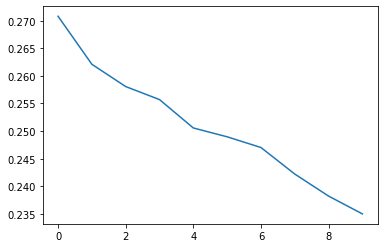

In [39]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [40]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
    """Generates a note IDs using a trained sequence model."""

    assert temperature > 0

  # Add batch dimension
    inputs = tf.expand_dims(notes, 0)

    predictions = model.predict(inputs)
    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']

    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)
    duration = tf.squeeze(duration, axis=-1)
    step = tf.squeeze(step, axis=-1)

    # `step` and `duration` values should be non-negative
    step = tf.maximum(0, step)
    duration = tf.maximum(0, duration)

    return int(pitch), float(step), float(duration)

In [41]:
temperature = 5.0
num_predictions = 30

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, temperature)
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

generated_notes = pd.DataFrame(generated_notes, columns=(*key_order, 'start', 'end'))

In [42]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,63,0.151963,0.340374,0.151963,0.492337
1,81,1.542991,0.070376,1.694954,1.765330
2,82,1.740641,0.099049,3.435595,3.534644
3,33,1.803161,0.093092,5.238756,5.331848
4,46,1.210896,0.021931,6.449652,6.471583
5,65,1.668717,0.000784,8.118369,8.119153
6,82,1.762597,0.039167,9.880966,9.920132
7,48,1.830142,0.065905,11.711107,11.777012
8,69,1.669330,0.008998,13.380437,13.389435
9,69,1.784359,0.046828,15.164795,15.211623


In [43]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name='Acoustic Grand Piano')